In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt


# Load the provided Excel file
file_path = 'Price.xlsx'
data = pd.ExcelFile(file_path)

# Load the sheet named 'data' to explore its content
df = data.parse('data')

# Display the first few rows of the dataframe to understand its structure
df.head()


,HourUTC,HourDK,PriceArea,PriceDKK,PriceEUR
0,2020-12-31 23:00:00,2021-01-01,DE,378.519989,50.869999
1,2020-12-31 23:00:00,2021-01-01,SE3,185.649994,24.950001
2,2020-12-31 23:00:00,2021-01-01,DK2,378.519989,50.869999
3,2020-12-31 23:00:00,2021-01-01,DK1,378.519989,50.869999
4,2020-12-31 23:00:00,2021-01-01,NO2,185.649994,24.950001


In [7]:
# Display unique PriceArea regions in the dataset
unique_regions = df['PriceArea'].unique()
unique_regions

array(['DE', 'SE3', 'DK2', 'DK1', 'NO2', 'SE4', 'SYSTEM'], dtype=object)

Total number of elements in the dataframe for region 'DK2': 23783
Number of elements in each category (equal-sized bins):
Category
Category 1    5946
Category 2    5946
Category 3    5945
Category 4    5946
Name: count, dtype: int64


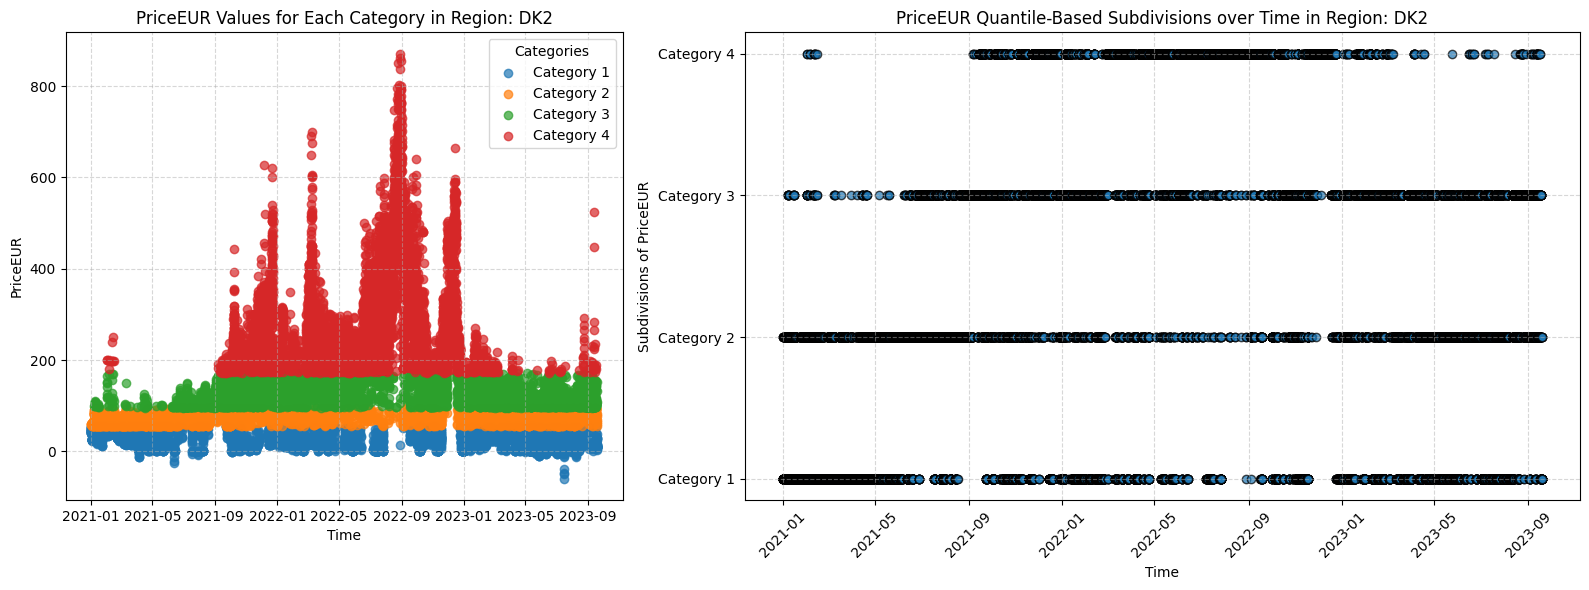

In [ ]:
def plot_qcut(df, region, column, subdivisions, time_column):
    """
    Create a subplot with the quantile-based subdivisions scatter plot on the right and 
    line plots of the prices for each category on the left.
    
    Parameters:
        df (pd.DataFrame): The input dataframe containing the data.
        region (str): The region to filter the data by.
        column (str): The column to analyze and plot.
        subdivisions (int): The number of quantile-based subdivisions for the column.
        time_column (str): The time column to use for the x-axis.
    
    Returns:
        None: Displays a subplot with the quantile-based subdivisions and category line plots.
    """
    # Filter the dataframe by region
    region_df = df[df['PriceArea'] == region].copy()
    
    # Print the total number of elements in the dataframe for the specified region
    total_elements = len(region_df)
    print(f"Total number of elements in the dataframe for region '{region}': {total_elements}")

    # Discretize the column into quantile-based subdivisions
    labels = [f"Category {i+1}" for i in range(subdivisions)]
    region_df['Category'] = pd.qcut(region_df[column], q=subdivisions, labels=labels)
    
    # Print the number of elements in each category
    category_counts = region_df['Category'].value_counts().sort_index()
    print("Number of elements in each category (equal-sized bins):")
    print(category_counts)
    
    # Convert the time column to datetime format for better plotting
    region_df[time_column] = pd.to_datetime(region_df[time_column])
    
    # Set up subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 3]})
    
    # Plot line plots of prices for each category (left plot)
    for category in labels:
        category_df = region_df[region_df['Category'] == category]
        axes[0].scatter(category_df[time_column], category_df[column], label=category, alpha=0.7)
    axes[0].set_title(f"{column} Values for Each Category in Region: {region}")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel(column)
    axes[0].legend(title="Categories")
    axes[0].grid(True, linestyle='--', alpha=0.5)
    
    # Plot scatter plot of quantile-based subdivisions (right plot)
    axes[1].scatter(region_df[time_column], region_df['Category'], alpha=0.7, edgecolor='k')
    axes[1].set_title(f"{column} Quantile-Based Subdivisions over Time in Region: {region}")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel(f"Subdivisions of {column}")
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# Example usage: Plot with subplots for region 'DK2' by 'HourDK'
plot_qcut(df, region='DK2', column='PriceEUR', subdivisions=4, time_column='HourDK')

   

In [24]:
def calculate_transition_matrix(df, region, column, subdivisions):
    """
    Calculate a transition matrix for a given column in a specific region using quantile-based subdivisions.
    
    Parameters:
        df (pd.DataFrame): The input dataframe containing the data.
        region (str): The region to filter the data by.
        column (str): The name of the column to analyze.
        subdivisions (int): The number of quantile-based subdivisions for the data.
    
    Returns:
        pd.DataFrame: A transition matrix showing probabilities of moving between categories.
    """
    # Filter data for the specified region
    region_df = df[df['PriceArea'] == region].copy()
    
    # Discretize the column into quantile-based categories using pd.qcut
    labels = [f"Category {i+1}" for i in range(subdivisions)]
    region_df['Category'] = pd.qcut(region_df[column], q=subdivisions, labels=labels)
    
    # Calculate transitions between categories
    transitions = pd.crosstab(region_df['Category'][:-1].values, region_df['Category'][1:].values, normalize='index')
    
    return transitions

# Example usage on region 'DK2', column 'PriceEUR', with 3 subdivisions
region = 'DK2'
subdivisions = 4
transition_matrix = calculate_transition_matrix(df, region, 'PriceEUR', subdivisions)
transition_matrix


col_0,Category 1,Category 2,Category 3,Category 4
row_0,,,,
Category 1,0.897393,0.092178,0.008915,0.001514
Category 2,0.095695,0.793475,0.107467,0.003364
Category 3,0.005719,0.112868,0.814130,0.067283
Category 4,0.001177,0.001514,0.069458,0.927851


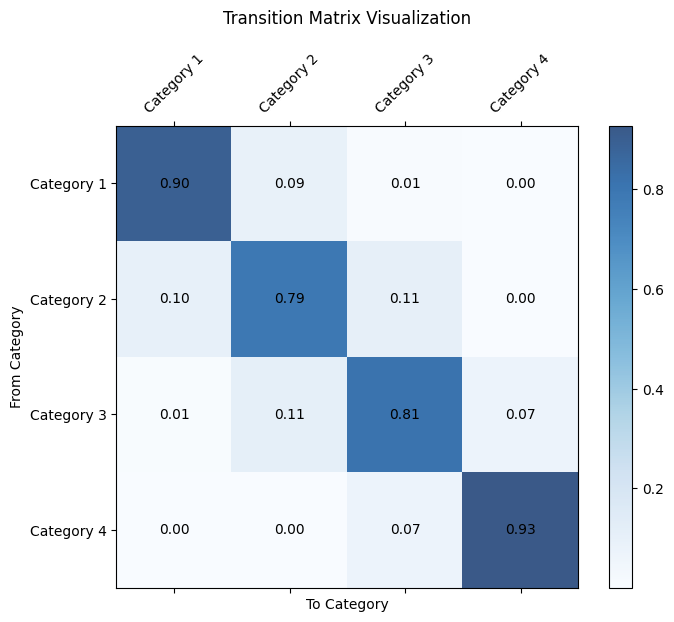

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(transition_matrix, cmap='Blues', alpha=0.8)

# Add text annotations
for (i, j), val in np.ndenumerate(transition_matrix.values):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

# Formatting the plot
plt.xticks(range(len(transition_matrix.columns)), transition_matrix.columns, rotation=45)
plt.yticks(range(len(transition_matrix.index)), transition_matrix.index)
plt.title("Transition Matrix Visualization", pad=20)
plt.xlabel("To Category")
plt.ylabel("From Category")
plt.colorbar(cax)
plt.show()
